# **Analisis de Datos Multimodales para MIR**
### **Tarea 1**: "*MIR con FMA*"
### **CIMAT** Monterrey
*Diego Paniagua Molina*

---

## **0)** *Preliminares* 

### Configuracion inicial del entorno.

In [28]:

# Imports
import os, gc, json, math, time, pickle, random
import numpy as np
import pandas as pd
from pathlib import Path

# Visualización
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay

# Pytorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Semilla
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Cuda
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cpu')

### Gestion de rutas para el proyecto.

In [4]:

# Rutas del proyecto
PROJ = Path(".").resolve()
DATA = PROJ / "data"
TRAIN = DATA / "train"
TEST = DATA / "test"
FIGS = PROJ / "figures"
MODELS = PROJ / "models"
ARTIFACTS = PROJ / "artifacts"
SUBM = PROJ / "submissions"
REPORTS = PROJ / "reports"

# Creacion automatica de directorios
for d in [FIGS, MODELS, ARTIFACTS, SUBM, REPORTS]:
    d.mkdir(parents=True, exist_ok=True)

# Archivos de  metadata
train_metadata_path = TRAIN / "tracks_fma_train_metadata.csv"
test_metadata_path = TEST / "tracks_fma_test_metadata.csv"

# Archivos de features a combinar
FEATURE_FILES = [
    "tracks_fma_{split}_audio_features.csv",
    "tracks_fma_{split}_chromacens_features.csv",
    "tracks_fma_{split}_chromacqt_features.csv",
    "tracks_fma_{split}_chromastft_features.csv",
    "tracks_fma_{split}_mfcc_features.csv",
    "tracks_fma_{split}_rmse_features.csv",
    "tracks_fma_{split}_spectral_features.csv",
    "tracks_fma_{split}_tonnetz_features.csv",
    "tracks_fma_{split}_zcr_features.csv",
    "tracks_fma_{split}_social_features.csv",
]

# Funicion para guardar figuras
def savefig(name, dpi=150):
    path = FIGS / name
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"Guardada: {path}")


### Funciones para carga y union de datos.

In [5]:

#  Lectura y limpieza básica para estandarizar archivos de metadatos
def read_metadata(meta_path: Path, split: str) -> pd.DataFrame:
    df = pd.read_csv(meta_path)
    # estandarizamos nombres de columnas
    df.columns = [c.strip() for c in df.columns]
    # asegurar tipos
    if "track_id" in df.columns:
        df["track_id"] = df["track_id"].astype(int)
    # renombrar etiqueta si existe
    if split == "train" and "track.genre1" in df.columns:
        df = df.rename(columns={"track.genre1": "genre"})
    return df

# Lectura y validacion de todos los archivos de features para unificar datasets
def read_features(dir_path: Path, split: str) -> list[pd.DataFrame]:
    frames = []
    for tpl in FEATURE_FILES:
        fname = tpl.format(split=split)
        fpath = dir_path / fname
        if not fpath.exists():
            print(f"[WARN] No encontrado: {fpath}")
            continue
        df = pd.read_csv(fpath)
        df.columns = [c.strip() for c in df.columns]
        if "track_id" not in df.columns:
            raise ValueError(f"{fname} no tiene columna 'track_id'")
        # prefijar columnas para saber su procedencia
        pref = fname.replace(f"tracks_fma_{split}_", "").replace(".csv","")
        num_cols = [c for c in df.columns if c != "track_id"]
        df = df[["track_id"] + num_cols].copy()
        df = df.rename(columns={c: f"{pref}__{c}" for c in num_cols})
        frames.append(df)
    return frames

# Generacion del Pipeline
def build_matrix(split: str = "train") -> tuple[pd.DataFrame, pd.Series | None]:
    base_dir = TRAIN if split == "train" else TEST
    meta = read_metadata(train_metadata_path if split=="train" else test_metadata_path, split)
    feats = read_features(base_dir, split)
    # merge progresivo por track_id
    X = meta[["track_id"]].copy()
    for f in feats:
        X = X.merge(f, on="track_id", how="left")
    # separar target
    y = None
    if split == "train" and "genre" in meta.columns:
        y = meta.set_index("track_id").loc[X["track_id"], "genre"].reset_index(drop=True)
    return X, y


Definimos este conjunto de funciones (`read_metadata`, `read_features`, `build_matrix`) para leer los múltiples archivos `.csv` de features, limpiarlos, y ensamblarlos en una única matriz de características $X$ y un vector de etiquetas $y$.

## **1)** *EDA* 

### Carga y exploracion de los datos.

In [6]:

# Cargar matrices de train y test
X_train_raw, y_train = build_matrix("train")
X_test_raw, _ = build_matrix("test")

# Visualizacion y dimensiones
print(f'Dimensiones: ',X_train_raw.shape, X_test_raw.shape)
display(X_train_raw.head())
if y_train is not None:
    display(y_train.value_counts().head())


Dimensiones:  (12472, 532) (657, 532)


,track_id,audio_features__audio_features.acousticness,audio_features__audio_features.danceability,audio_features__audio_features.energy,audio_features__audio_features.instrumentalness,audio_features__audio_features.liveness,audio_features__audio_features.speechiness,audio_features__audio_features.tempo,audio_features__audio_features.valence,chromacens_features__chromacens.kurtosis.01,...,zcr_features__zcr.mean.01,zcr_features__zcr.median.01,zcr_features__zcr.min.01,zcr_features__zcr.skew.01,zcr_features__zcr.std.01,social_features__social_features.artist_discovery,social_features__social_features.artist_familiarity,social_features__social_features.artist_hotttnesss,social_features__social_features.song_currency,social_features__social_features.song_hotttnesss
0,28362,0.615845,0.796281,0.325478,8.875420e-01,0.115252,0.063696,115.151,0.640349,-0.854609,...,0.028092,0.020020,0.001953,2.369166,0.029650,0.262087,0.148808,0.273797,0.000000,0.000000
1,21945,0.220101,0.510654,0.969888,8.971400e-01,0.092763,0.128598,187.946,0.039892,-0.284995,...,0.091346,0.070801,0.000000,4.549640,0.080030,0.272543,0.100723,0.284720,0.000000,0.000000
2,12926,0.995025,0.366585,0.009510,3.110000e-08,0.126373,0.047308,110.612,0.375191,-0.658622,...,0.042644,0.035156,0.000977,4.588343,0.039720,0.118270,0.163611,0.123554,0.000250,0.038550
3,21232,0.431574,0.416715,0.665064,1.401447e-01,0.149772,0.033538,161.977,0.275170,-0.603870,...,0.055438,0.050293,0.000000,2.032553,0.031930,0.179076,0.035024,0.187077,0.000167,0.041556
4,17132,0.800596,0.554503,0.599560,1.740652e-01,0.430448,0.097078,96.597,0.224275,-0.060540,...,0.050421,0.046875,0.000000,2.237431,0.028344,0.210243,0.167889,0.219637,0.001750,0.132899


genre
Rock          4275
Electronic    2584
Pop           1313
Folk           910
Hip-Hop        865
Name: count, dtype: int64

### Preprocesamiento de los datos.

In [7]:

# Mantener solo columnas numéricas
num_cols = ["track_id"] + [c for c in X_train_raw.columns if c != "track_id" and pd.api.types.is_numeric_dtype(X_train_raw[c])]
X_train = X_train_raw[num_cols].copy()
X_test = X_test_raw[num_cols].copy()

# Imputación simple (si hubiera faltantes residuales)
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_test = X_test.fillna(X_train.median(numeric_only=True))
print("Num features:", X_train.shape[1]-1)

# Artefactos de entrenamiento
FEATURES_USED = [c for c in X_train.columns if c != "track_id"]
TRAIN_MEDIANS = X_train.drop(columns=["track_id"]).median(numeric_only=True).to_dict()

with open(ARTIFACTS / "features_used.json", "w") as f:
    json.dump(FEATURES_USED, f)

with open(ARTIFACTS / "train_medians.json", "w") as f:
    json.dump({k: float(v) for k, v in TRAIN_MEDIANS.items()}, f)

print(f"Guardadas {len(FEATURES_USED)} columnas y medianas de train.")


Num features: 531
Guardadas 531 columnas y medianas de train.


### Distribución de la variable objetivo.

genre
Rock                   4275
Electronic             2584
Pop                    1313
Folk                    910
Hip-Hop                 865
International           788
Jazz                    480
Old-Time / Historic     384
Classical               380
Blues                   195
Country                 123
Instrumental             80
Experimental             41
Easy Listening           28
Soul-RnB                 26
Name: count, dtype: int64


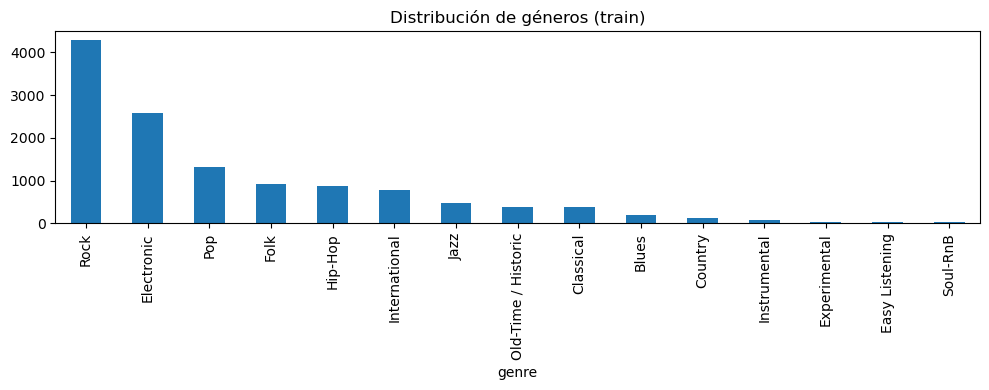

Guardada: /home/diego23/Master/cimat/multimodal-analysis-MIR/homework/01_intro_deep_learning/figures/eda_distribucion_generos.png


<Figure size 640x480 with 0 Axes>

In [8]:

# Distribución de la variable de respuesta
if y_train is not None:
    vc = y_train.value_counts().sort_values(ascending=False)
    print(vc.head(20))
    plt.figure(figsize=(10,4))
    vc.plot(kind="bar")
    plt.title("Distribución de géneros (train)")
    plt.tight_layout()
    plt.show()
    savefig("eda_distribucion_generos.png")



Podemos observar que el gráfico muestra un severo desbalance de clases con una distribución de cola larga. Las  clases **Rock**, **Electronic** y **Pop** dominan el dataset, mientras que los demas géneros tiene un soporte extremadamente bajo. Esta desvalance de clases sera el principal desafío del problema.

### Reduccion de dimensiones mediante PCA.

Varianza explicada (PC1, PC2): [0.11899027 0.0766737 ]


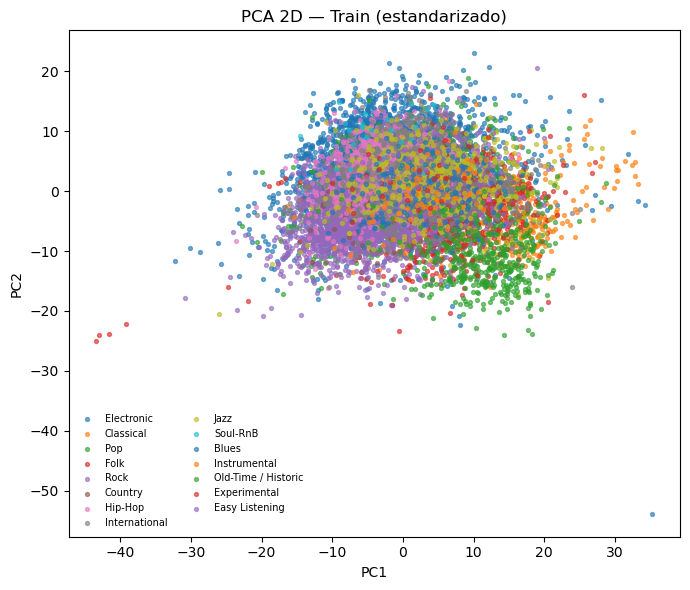

Guardada: /home/diego23/Master/cimat/multimodal-analysis-MIR/homework/01_intro_deep_learning/figures/pca_2d_train.png


<Figure size 640x480 with 0 Axes>

In [9]:

# Estandarización  de los datos
scaler = StandardScaler()
Xs = scaler.fit_transform(X_train.drop(columns=["track_id"]))

# PCA (2D)
pca = PCA(n_components=2, random_state=SEED)
Xp = pca.fit_transform(Xs)

# Varianza explicada
print("Varianza explicada (PC1, PC2):", pca.explained_variance_ratio_[:2])

# Visualizacion
if y_train is not None:
    # graficar dispersión 2D coloreada por género
    genres = y_train.astype(str).values
    uniq = pd.Series(genres).unique()
    plt.figure(figsize=(7,6))
    for g in uniq:
        m = genres==g
        plt.scatter(Xp[m,0], Xp[m,1], s=8, alpha=0.6, label=g)
    plt.legend(ncol=2, fontsize=7, frameon=False)
    plt.title("PCA 2D — Train (estandarizado)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()
    savefig("pca_2d_train.png")


En el grafico obtenido tras aplicar PCA en 2 dimensiones observamos una gran superposición entre los géneros lo que nos sugiere que la tarea de clasificación es compleja.

## **2)** *MLP*

### Preparacion para el entrenamiento del modelo. 

In [ ]:

# Codificación de etiquetas
le = LabelEncoder()
y_id = le.fit_transform(y_train)

# División train/val (80/20) estratificada
X_all = X_train.drop(columns=["track_id"]).values.astype(np.float32)

Xtr, Xva, ytr, yva = train_test_split(
    X_all, y_id, test_size=0.2, random_state=SEED, stratify=y_id
)

# Escalamiento en train
scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtr).astype(np.float32)
Xva = scaler.transform(Xva).astype(np.float32)

# PCA para estabilizar/compactar
#PCA_DIMS = 192
#pca = PCA(n_components=PCA_DIMS, random_state=SEED)
#Xtr = pca.fit_transform(Xtr).astype(np.float32)
#Xva = pca.transform(Xva).astype(np.float32)

n_features = Xtr.shape[1]
n_classes = len(le.classes_)
print("n_features:", n_features, "n_classes:", n_classes)

# Guarda artefactos
with open(ARTIFACTS / "label_encoder.pkl", "wb") as f: pickle.dump(le, f)
with open(ARTIFACTS / "scaler.pkl", "wb") as f: pickle.dump(scaler, f)
# PCA no se usó, guardar None
with open(ARTIFACTS / "pca.pkl", "wb") as f: pickle.dump(None, f)


n_features: 531 n_classes: 15


### Creación del dataset y DataLoader de PyTorch.

In [18]:

# Contenedor de datos
class TabDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = None if y is None else torch.tensor(y, dtype=torch.long)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx]) if self.y is not None else self.X[idx]

BATCH = 256
train_ds = TabDataset(Xtr, ytr)
val_ds   = TabDataset(Xva, yva)

# Sampler balanceado por clase
class_counts = np.bincount(ytr)
class_weights_sampler = (class_counts.sum() / (len(class_counts) * class_counts))
sample_weights = class_weights_sampler[ytr]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_dl = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=0)
val_dl   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=0)


### Definición del modelo MLP.

In [ ]:
# Arquitectura del modelo (mejor configuración hallada, sin PCA)
class MLP(nn.Module):
    def __init__(self, in_dim, n_classes, hidden=(768, 384, 192), pdrop=0.20):
        super().__init__()
        layers, last = [], in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.BatchNorm1d(h), nn.ReLU(), nn.Dropout(pdrop)]
            last = h
        layers += [nn.Linear(last, n_classes)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# Instancia del modelo
model = MLP(n_features, n_classes).to(DEVICE)
model


MLP(
  (net): Sequential(
    (0): Linear(in_features=531, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=768, out_features=384, bias=True)
    (5): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=384, out_features=192, bias=True)
    (9): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=192, out_features=15, bias=True)
  )
)

Se definio una red neuronal de tipo **Perceptrón Multicapa (MLP)** con una estructura secuencial y profunda, diseñada para la clasificación, la arquitectura es la siguiente:

* **Entrada**: La red acepta un vector de entrada con un tamaño de `n_features`.
* **Capas Ocultas**: Consiste en **tres bloques ocultos**:
    1.  **Bloque 1**: Una capa lineal que transforma la entrada a **768** neuronas.
    2.  **Bloque 2**: Una capa lineal que reduce la dimensionalidad a **384** neuronas.
    3.  **Bloque 3**: Una capa lineal que la reduce nuevamente a **192** neuronas.
* **Componentes de cada Bloque**: Cada uno de estos bloques incluye un conjunto de capas para mejorar el rendimiento y la regularización:
    * `BatchNorm1d`: Para estabilizar y acelerar el entrenamiento.
    * `ReLU`: Como función de activación no-lineal.
    * `Dropout`: Con una probabilidad del **20%** para prevenir el sobreajuste.
* **Capa de Salida**: Una capa lineal final que toma las 192 características del último bloque y las proyecta al número de clases (`n_classes`), produciendo las puntuaciones (logits) para la clasificación.

### Entrenamiento y validacion.

In [20]:

# Pérdida, optimizador y scheduler
def compute_class_ce_weights(y):
    counts = np.bincount(y)
    w = counts.sum() / (len(counts) * counts)
    # suaviza para evitar explosiones en clases con muy pocos ejemplos
    w = np.clip(w, 0.5, 5.0)
    return torch.tensor(w, dtype=torch.float32)

weights_ce = compute_class_ce_weights(ytr).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weights_ce, label_smoothing=0.05)

optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3, verbose=True)

# Hiperparámetros
EPOCHS   = 80
PATIENCE = 10
best_f1  = -1.0
best_state = None
wait = 0

history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": [], "lr": []}

# Entrenamiento y validación
for epoch in range(1, EPOCHS+1):
    # Entrenamiento
    model.train()
    total = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item() * xb.size(0)
    tr_loss = total / len(train_ds)

    # Validación
    model.eval()
    vtotal, all_logits, all_y = 0.0, [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            vtotal += loss.item() * xb.size(0)
            all_logits.append(logits.cpu()); all_y.append(yb.cpu())
    va_loss = vtotal / len(val_ds)

    logits = torch.cat(all_logits); y_true = torch.cat(all_y).numpy()
    y_pred = logits.argmax(1).numpy()
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")

    # Historial
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(acc)
    history["val_f1"].append(f1m)
    history["lr"].append(optimizer.param_groups[0]["lr"])

    scheduler.step(f1m)  # ajusta LR con base en macro-F1

    if f1m > best_f1:
        best_f1 = f1m
        best_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"Early stopping en época {epoch}. Mejor macro-F1: {best_f1:.4f}")
            break

    if epoch % 5 == 0 or epoch == 1:
        print(f"[{epoch:03d}] tr={tr_loss:.4f}  va={va_loss:.4f}  acc={acc:.4f}  f1m={f1m:.4f}  lr={optimizer.param_groups[0]['lr']:.2e}")

# Cargar mejor estado
if best_state is not None:
    model.load_state_dict(best_state)


/home/diego23/miniconda3/envs/mir-fma/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[001] tr=1.1932  va=2.6020  acc=0.1295  f1m=0.1597  lr=1.00e-03
[005] tr=0.4663  va=2.0340  acc=0.4305  f1m=0.3420  lr=1.00e-03
[010] tr=0.3857  va=1.9326  acc=0.5575  f1m=0.4255  lr=1.00e-03
[015] tr=0.3584  va=1.9081  acc=0.5980  f1m=0.4600  lr=1.00e-03
[020] tr=0.3452  va=1.8972  acc=0.6273  f1m=0.4721  lr=1.00e-03
[025] tr=0.3306  va=1.8772  acc=0.6429  f1m=0.4729  lr=5.00e-04
[030] tr=0.3136  va=1.8574  acc=0.6573  f1m=0.4856  lr=5.00e-04
[035] tr=0.3137  va=1.8740  acc=0.6525  f1m=0.4953  lr=5.00e-04
[040] tr=0.3105  va=1.8568  acc=0.6629  f1m=0.4976  lr=2.50e-04
[045] tr=0.3073  va=1.8676  acc=0.6569  f1m=0.4882  lr=2.50e-04
[050] tr=0.3048  va=1.8680  acc=0.6629  f1m=0.4966  lr=1.25e-04
[055] tr=0.3039  va=1.8573  acc=0.6669  f1m=0.5001  lr=1.25e-04
[060] tr=0.3036  va=1.8662  acc=0.6669  f1m=0.5040  lr=6.25e-05
[065] tr=0.3035  va=1.8653  acc=0.6693  f1m=0.4994  lr=3.13e-05
Early stopping en época 68. Mejor macro-F1: 0.5065


### Visualizacion historial de entrenamiento. 

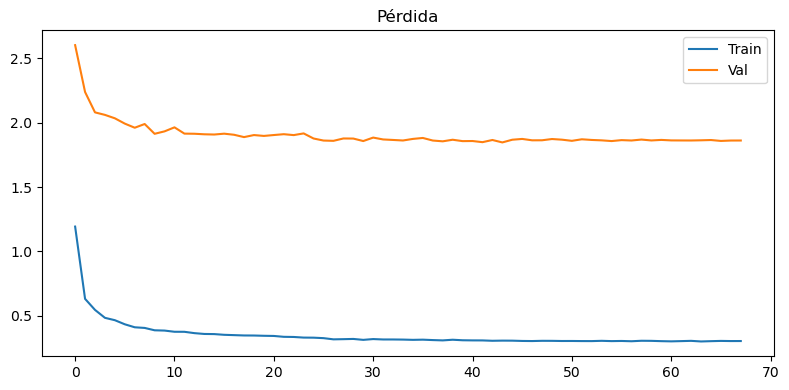

Guardada: /home/diego23/Master/cimat/multimodal-analysis-MIR/homework/01_intro_deep_learning/figures/curva_perdida.png


<Figure size 640x480 with 0 Axes>

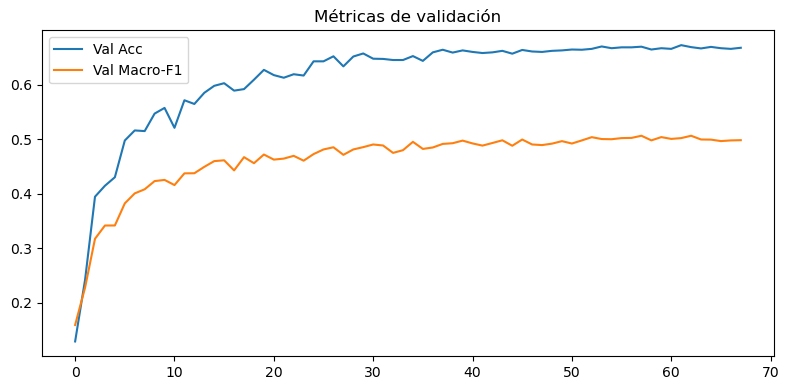

Guardada: /home/diego23/Master/cimat/multimodal-analysis-MIR/homework/01_intro_deep_learning/figures/metricas_validacion.png


<Figure size 640x480 with 0 Axes>

In [31]:

# Curva de pérdida
plt.figure(figsize=(8,4))
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.title("Pérdida"); plt.legend()
plt.tight_layout(); plt.show()
savefig("curva_perdida.png")

# Métricas de validación
plt.figure(figsize=(8,4))
plt.plot(history["val_acc"], label="Val Acc")
plt.plot(history["val_f1"], label="Val Macro-F1")
plt.title("Métricas de validación"); plt.legend()
plt.tight_layout(); plt.show()
savefig("metricas_validacion.png")



Podemos observar que el gráfico de "Pérdida" muestra un **sobreajuste (overfitting)**.

* La *pérdida de entrenamiento (Train)* desciende rápidamente y se estabiliza en un valor muy bajo, lo que indica que el modelo se ha ajustado muy bien a los datos de entrenamiento.
* La *pérdida de validación (Val)*, aunque desciende al principio, se estanca en un valor mucho más alto.

La gran brecha entre ambas curvas nos indica que el modelo *memorizo* los datos de entrenamiento pero no generaliza igual de bien a los datos nuevos que no ha visto.

---

Por otra parte el gráfico de "Métricas de validación" expone el **impacto del desbalance de clases** en el rendimiento del modelo.

* Ambas métricas, *Accuracy (Val Acc)* y *Macro-F1 (Val Macro-F1)*, mejoran y se estabilizan, lo que confirma que el modelo está aprendiendo.
* Sin embargo, la *Accuracy* se estabiliza en un valor notablemente más alto (~68%) que el **Macro-F1** (~50%).

Esta diferencia se debe a que la *Accuracy* puede ser alta si el modelo acierta en las clases mayoritarias, mientras que el *Macro-F1* penaliza duramente el mal rendimiento en las clases minoritarias (con pocas muestras). En resumen, el modelo es relativamente bueno prediciendo los géneros más comunes, pero sufre para identificar correctamente los géneros raros.

### Metricas obtenidas.

In [ ]:

# Reporte final en validación
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(Xva, dtype=torch.float32).to(DEVICE)).cpu().numpy()
y_pred = logits.argmax(1)
print(classification_report(yva, y_pred, target_names=le.classes_))

# Guardar artefactos
import pickle
torch.save(model.state_dict(), MODELS / "mlp_fma.pt")
with open(ARTIFACTS / "label_encoder.pkl", "wb") as f: pickle.dump(le, f)
with open(ARTIFACTS / "scaler.pkl", "wb") as f: pickle.dump(scaler, f)

# Guardar historial
with open(REPORTS / "history.json", "w") as f: json.dump(history, f, indent=2)


                     precision    recall  f1-score   support

              Blues       0.68      0.64      0.66        39
          Classical       0.76      0.86      0.81        76
            Country       0.56      0.36      0.44        25
     Easy Listening       0.00      0.00      0.00         5
         Electronic       0.66      0.71      0.68       517
       Experimental       0.00      0.00      0.00         8
               Folk       0.57      0.57      0.57       182
            Hip-Hop       0.61      0.66      0.64       173
       Instrumental       0.60      0.38      0.46        16
      International       0.58      0.50      0.54       158
               Jazz       0.59      0.49      0.53        96
Old-Time / Historic       0.96      0.95      0.95        77
                Pop       0.45      0.40      0.43       263
               Rock       0.76      0.79      0.77       855
           Soul-RnB       0.00      0.00      0.00         5

           accuracy   

## **3)** *Predicción*

### Prediccion y generación de la entrega de resultados.

In [ ]:
# Aplicar el mismo preprocesamiento que en entrenamiento
X_test_processed = X_test_raw[FEATURES_USED].copy()
X_test_processed = X_test_processed.fillna(pd.Series(TRAIN_MEDIANS))

# Escalar con el scaler entrenado
X_te = scaler.transform(X_test_processed.astype(np.float32).values).astype(np.float32)

# Cargar checkpoint y hacer predicción
ckpt_path = MODELS / "mlp_fma.pt"
state = torch.load(ckpt_path, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# Inferencia
with torch.no_grad():
    logits = model(torch.tensor(X_te, dtype=torch.float32, device=DEVICE)).cpu().numpy()
yhat = logits.argmax(1)
pred_genres = le.inverse_transform(yhat)

# Generar submission
sub_path = SUBM / "submission_mlp.csv"
pd.DataFrame({"track_id": X_test_raw["track_id"].astype(int).values,
              "genre": pred_genres}).to_csv(sub_path, index=False)
print(f"Submission generada: {sub_path}")

Submission generada: /home/diego23/Master/cimat/multimodal-analysis-MIR/homework/01_intro_deep_learning/submissions/submission_mlp.csv


/tmp/ipykernel_97775/3441494184.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=DEVICE)


Matriz de confusion normalizada.

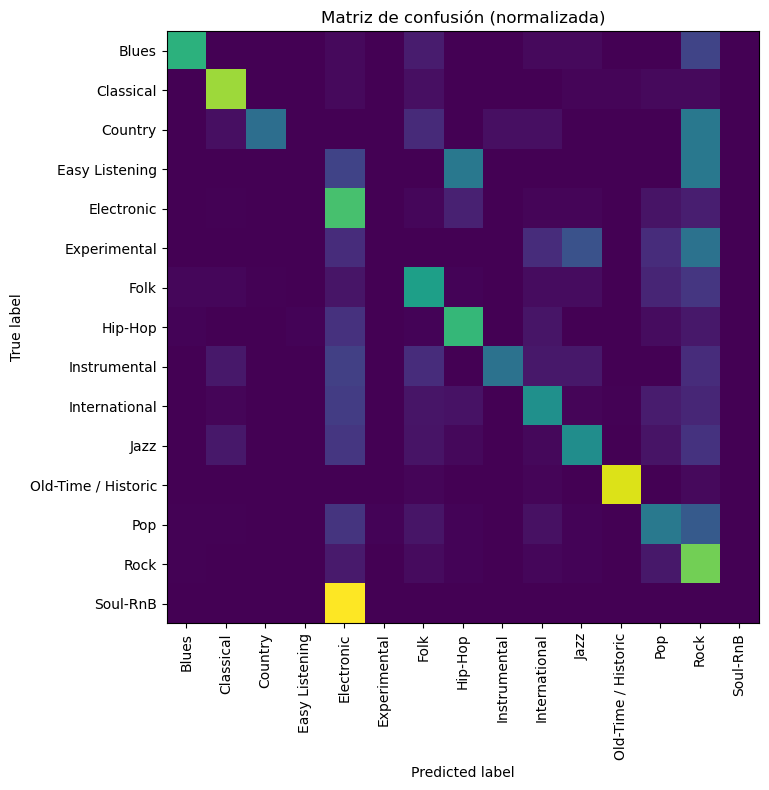

Guardada: /home/diego23/Master/cimat/multimodal-analysis-MIR/homework/01_intro_deep_learning/figures/confusion_normalizada.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Generamos la matriz de confusion
cm = confusion_matrix(yva, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(include_values=False, cmap="viridis", ax=ax, xticks_rotation=90, colorbar=False)
plt.title("Matriz de confusión (normalizada)")
plt.tight_layout(); plt.show()
savefig("confusion_normalizada.png")


Podemos ver que la matriz de confusion confirma que el modelo no es un clasificador generalista robusto. Aunque ha aprendido a reconocer perfectamente ciertos géneros muy distintivos, sufre de un fuerte sesgo y tiene confusiones sistemáticas que limitan su funcionamiento en los géneros con menos muestras.